In [ ]:
!nvidia-smi

In [ ]:
pip install transformers datasets evaluate seqeval[cuda]
pip install -U bitsandbytes==0.40.0

In [ ]:
pip install pandas

In [ ]:
pip install mpi4py

In [ ]:
pip install transformers seqeval[gpu]

In [ ]:
pip install scikit-learn

In [ ]:
pip install ray

In [ ]:
pip install pydantic==1.10.13

In [ ]:
pip install modin

In [49]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=f00fb62a0a1b6b58a1a40ffe9947677e81a729ab218e1f12e0c74f6e1698f5be
  Stored in directory: /home/sridhanya_ganapathi_team_neustar/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


https://data.world/collery/post-office-data/workspace/file?filename=USPO+Change+of+Address+data+Y2022.csv
https://data.world/len/us-first-names-database

https://www.kaggle.com/datasets/ahmedshahriarsakib/list-of-real-usa-addresses
https://www.kaggle.com/datasets/datagov/usa-names

https://data.world/adamhelsinger/directory-of-representatives
https://data.world/state-of-connecticut/ikyf-f2iu

In [1]:
import pandas as pd

In [2]:
import transformers

print(transformers.__version__)

4.36.0.dev0


In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
task = "ner" # Should be one of "ner", "pos" or "chunk"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

In [5]:
# Define the labels for each column
labels = ['firstname', 'gender', 'lastname', 'zipcode', 'city', 'state']


In [6]:
from huggingface_hub import notebook_login

notebook_login()

In [7]:
from datasets import load_dataset, load_metric



In [8]:
from datasets import concatenate_datasets, Dataset, load_from_disk, DatasetDict

train_dataset=load_from_disk("./data/traindatasethg_name_label_list")
test_dataset=load_from_disk("./data/testdatasethg_namelabel_list")

In [9]:
train_dataset[len(train_dataset)-100]

{'id': 'e537dade-7f29-4f32-b78f-dcb41012d372',
 'token': '46898',
 'ner_tag': [4]}

In [10]:
finalds = DatasetDict({
    'train': train_dataset,
    'test': test_dataset})

In [11]:
finalds['train'][0]

{'id': '687d88dc-53a2-4b94-858d-624a9b84264f',
 'token': 'zeyad',
 'ner_tag': [0]}

In [12]:
finalds["train"].features[f"ner_tag"]


Sequence(feature=ClassLabel(names=['firstname', 'lastname', 'city', 'state', 'zipcode'], id=None), length=-1, id=None)

In [13]:
label_list = finalds["train"].features[f"ner_tag"].feature.names


In [14]:
label_list

['firstname', 'lastname', 'city', 'state', 'zipcode']

In [15]:
labels=label_list
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
label2id

{'firstname': 0, 'lastname': 1, 'city': 2, 'state': 3, 'zipcode': 4}

In [16]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


In [17]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [18]:
example = finalds["train"][0]
tokenized_input = tokenizer(example["token"], is_split_into_words=False)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['[CLS]', 'ze', '##yad', '[SEP]']

In [19]:
 finalds["test"][0]

{'id': 'b63dc4f4-6813-48fc-833a-5585f09dbc1e',
 'token': 'teron',
 'ner_tag': [0]}

In [20]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["token"], truncation=True, is_split_into_words=False)
    tokenized_inputs["labels"] = examples[f"ner_tag"]
    return tokenized_inputs

In [21]:
finalds['train'].features

{'id': Value(dtype='string', id=None),
 'token': Value(dtype='string', id=None),
 'ner_tag': Sequence(feature=ClassLabel(names=['firstname', 'lastname', 'city', 'state', 'zipcode'], id=None), length=-1, id=None)}

In [22]:
tokenized_inputs = finalds.map(tokenize_and_align_labels, batched=True)


In [23]:

example = tokenized_inputs['train'][0]
print(example.keys())

dict_keys(['id', 'token', 'ner_tag', 'input_ids', 'attention_mask', 'labels'])


In [24]:
tokenizer.decode(example['input_ids'])


2023-12-07 18:02:32.462505: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-07 18:02:32.516021: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 18:02:32.516054: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 18:02:32.516131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 18:02:32.525777: I tensorflow/core/platform/cpu_feature_g

'[CLS] zeyad [SEP]'

In [25]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list), label2id=label2id, id2label=id2label)
model.to(device)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/sridhanya_ganapathi_team_neustar/llm/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda121.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.9
CUDA SETUP: Detected CUDA version 121
CUDA SETUP: Loading binary /home/sridhanya_ganapathi_team_neustar/llm/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda121.so...


/home/sridhanya_ganapathi_team_neustar/llm/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /opt/conda/envs/llm did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

In [26]:
# tokenized_inputs.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])

model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    num_train_epochs=3,
    save_total_limit=2,
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True,
    push_to_hub=False,
)

In [27]:
from transformers import DataCollatorForTokenClassification, EarlyStoppingCallback

data_collator = DataCollatorForTokenClassification(tokenizer)

In [28]:
metric = load_metric("seqeval")

/var/tmp/ipykernel_110055/152412463.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [29]:
labels = [label_list[i] for i in example[f"{task}_tag"]]

In [30]:
labels

['firstname']

In [31]:
labels = [label_list[i] for i in example[f"{task}_tag"]]
metric.compute(predictions=[labels], references=[labels])

/home/sridhanya_ganapathi_team_neustar/llm/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: firstname seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'irstname': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [52]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    print(results)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [33]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_inputs["train"],
    eval_dataset=tokenized_inputs["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[
             EarlyStoppingCallback(early_stopping_patience=3)
        ],
   )

In [34]:
trainer.train()


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.304000,0.262851,0.903546,0.903546,0.903546,0.903546
2,0.215600,0.272315,0.908897,0.908897,0.908897,0.908897
3,0.169900,0.293254,0.909619,0.909619,0.909619,0.909619


/home/sridhanya_ganapathi_team_neustar/llm/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: firstname seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/sridhanya_ganapathi_team_neustar/llm/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: lastname seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/sridhanya_ganapathi_team_neustar/llm/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: city seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/sridhanya_ganapathi_team_neustar/llm/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: state seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/sridhanya_ganapathi_team_neustar/llm/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning:

TrainOutput(global_step=22845, training_loss=0.22983420879842417, metrics={'train_runtime': 1148.0965, 'train_samples_per_second': 318.37, 'train_steps_per_second': 19.898, 'total_flos': 515719841756640.0, 'train_loss': 0.22983420879842417, 'epoch': 3.0})

In [35]:
test_score = trainer.evaluate()


/home/sridhanya_ganapathi_team_neustar/llm/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: firstname seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/sridhanya_ganapathi_team_neustar/llm/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: lastname seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/sridhanya_ganapathi_team_neustar/llm/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: city seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/sridhanya_ganapathi_team_neustar/llm/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: state seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/sridhanya_ganapathi_team_neustar/llm/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning:

In [36]:
test_score

{'eval_loss': 0.26285120844841003,
 'eval_precision': 0.9035456336178594,
 'eval_recall': 0.9035456336178594,
 'eval_f1': 0.9035456336178594,
 'eval_accuracy': 0.9035456336178594,
 'eval_runtime': 17.3929,
 'eval_samples_per_second': 1751.29,
 'eval_steps_per_second': 109.47,
 'epoch': 3.0}

In [37]:
from sklearn.metrics import classification_report,confusion_matrix
predictions, labels, _ = trainer.predict(tokenized_inputs["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)

# results

In [38]:
from sklearn.metrics import classification_report,confusion_matrix
print("\n*Classification Report:\n", classification_report(true_labels, true_predictions))
confusion_matrix_graph = confusion_matrix(true_labels, true_predictions)


*Classification Report:
               precision    recall  f1-score   support

        city       0.92      0.87      0.89      6092
   firstname       0.84      0.80      0.82      6092
    lastname       0.78      0.85      0.81      6092
       state       1.00      1.00      1.00      6092
     zipcode       1.00      1.00      1.00      6092

    accuracy                           0.90     30460
   macro avg       0.91      0.90      0.90     30460
weighted avg       0.91      0.90      0.90     30460



In [39]:
confusion_matrix_graph

array([[5286,  245,  560,    1,    0],
       [ 259, 4896,  935,    2,    0],
       [ 225,  710, 5156,    1,    0],
       [   0,    0,    0, 6092,    0],
       [   0,    0,    0,    0, 6092]])

<Axes: >

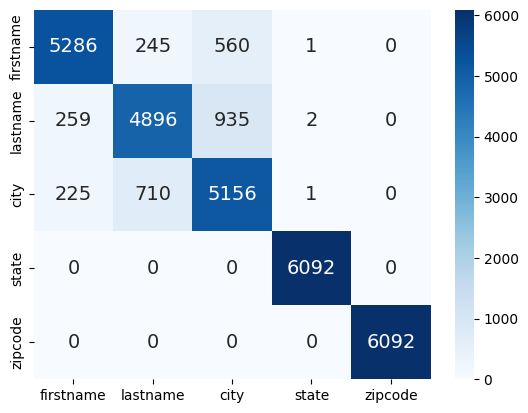

In [40]:
import seaborn as sns
sns.heatmap(confusion_matrix_graph, fmt=".0f", annot=True, cmap='Blues',xticklabels=label_list,
                yticklabels=label_list,
                annot_kws={"fontsize":14})

In [41]:
model.save_pretrained("./model/classification-ner-huggingface-trainer")
tokenizer.save_pretrained("./model/classification-ner-huggingface-trainer")

('./model/classification-ner-huggingface-trainer/tokenizer_config.json',
 './model/classification-ner-huggingface-trainer/special_tokens_map.json',
 './model/classification-ner-huggingface-trainer/vocab.txt',
 './model/classification-ner-huggingface-trainer/added_tokens.json',
 './model/classification-ner-huggingface-trainer/tokenizer.json')

In [42]:
model.to(device)

DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

In [43]:
model_saved = AutoModelForTokenClassification.from_pretrained("./model/classification-ner-huggingface-trainer/")
model_saved = model_saved.to(device)

In [44]:
from transformers import AutoModelForTokenClassification

model_saved = AutoModelForTokenClassification.from_pretrained("./model/classification-ner-huggingface-trainer/")
tokenizer_saved = AutoTokenizer.from_pretrained("./model/classification-ner-huggingface-trainer/")

In [45]:
from transformers import pipeline

text = ["john"]
ner = pipeline(
            task="ner", 
            model=model_saved,
            tokenizer=tokenizer_saved
        )
ner(text)

[[{'entity': 'firstname',
   'score': 0.5678732,
   'index': 1,
   'word': 'john',
   'start': 0,
   'end': 4}]]

In [46]:
from datasets import list_metrics
metrics_list = list_metrics()
len(metrics_list)
print(metrics_list)

# ['accuracy', 'bertscore', 'bleu', 'bleurt', 'cer', 'comet', 'coval', 'cuad', 'f1', 'gleu', 'glue', 
#  'indic_glue', 'matthews_correlation', 'meteor', 'pearsonr', 'precision', 'recall', 'rouge', 'sacrebleu',
#  'sari', 'seqeval', 'spearmanr', 'squad', 'squad_v2', 'super_glue', 'wer', 'wiki_split', 'xnli']


['accuracy', 'bertscore', 'bleu', 'bleurt', 'brier_score', 'cer', 'character', 'charcut_mt', 'chrf', 'code_eval', 'comet', 'competition_math', 'coval', 'cuad', 'exact_match', 'f1', 'frugalscore', 'glue', 'google_bleu', 'indic_glue', 'mae', 'mahalanobis', 'mape', 'mase', 'matthews_correlation', 'mauve', 'mean_iou', 'meteor', 'mse', 'nist_mt', 'pearsonr', 'perplexity', 'poseval', 'precision', 'r_squared', 'recall', 'rl_reliability', 'roc_auc', 'rouge', 'sacrebleu', 'sari', 'seqeval', 'smape', 'spearmanr', 'squad', 'squad_v2', 'super_glue', 'ter', 'trec_eval', 'wer', 'wiki_split', 'xnli', 'xtreme_s', 'AlhitawiMohammed22/CER_Hu-Evaluation-Metrics', 'BucketHeadP65/confusion_matrix', 'BucketHeadP65/roc_curve', 'DarrenChensformer/eval_keyphrase', 'DarrenChensformer/relation_extraction', 'Drunper/metrica_tesi', 'Felipehonorato/eer', 'GMFTBY/dailydialog_evaluate', 'GMFTBY/dailydialogevaluate', 'He-Xingwei/sari_metric', 'Ikala-allen/relation_extraction', 'JP-SystemsX/nDCG', 'Josh98/nl2bash_m', '

/var/tmp/ipykernel_110055/1722447465.py:2: FutureWarning: list_metrics is deprecated and will be removed in the next major version of datasets. Use 'evaluate.list_evaluation_modules' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metrics_list = list_metrics()
